# Face Generation using GANs
Generative Adversarial Networks to generate new images of faces.


Datasets:
- CelebA

Download the dataset from [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and put the image_align_celeba folder in the data directory

Found celeba Data


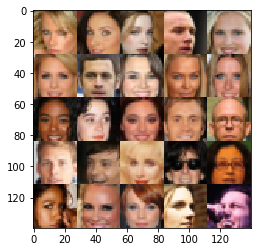

In [5]:
data_dir = './data'

import helper
helper.download_extract('celeba', data_dir)

show_n_images = 25

%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess Data
The values of the CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images. The images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None))
    return inputs_real, inputs_z, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator

In [9]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

def discriminator(images, reuse=False):

    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(x, 64, 5, strides=2, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                             padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = lrelu(x, 0.2)

        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                             padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = lrelu(x, 0.2)

        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                             padding="same")
        x = tf.layers.batch_normalization(x, training=True)
        x = lrelu(x, 0.2)

        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator

In [10]:
def generator(z, out_channel_dim, is_train=True):

    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512)        
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = lrelu(x, 0.2)

        x = tf.layers.conv2d_transpose(x, 128, 4, strides=1, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                                       padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = lrelu(x, 0.2)

        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                                       padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = lrelu(x, 0.2)
        
        x = tf.layers.conv2d_transpose(x, 32, 5, strides=2, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                                       padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = lrelu(x, 0.2)

        x = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer = tf.contrib.layers.xavier_initializer(), 
                                       padding="same")
        
        out = tf.tanh(x)

    return out

tests.test_generator(generator, tf)

Tests Passed


### Loss

In [11]:
def model_loss(input_real, input_z, out_channel_dim):

    smooth = 0.1    
    _, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
    
    d_logits_fake = discriminator(fake, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss

tests.test_model_loss(model_loss)

Tests Passed


### Optimization

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):

    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

tests.test_model_opt(model_opt, tf)

Tests Passed


### Display Output

In [13]:
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

## Training

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    step = 0 
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                step = step+1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, lr:learning_rate})
                
                if step % 100 == 0:
                    train_loss_d = d_loss.eval({inputs_z:batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, step),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

Epoch 1/1 Step 100... Discriminator Loss: 1.3541... Generator Loss: 1.2495


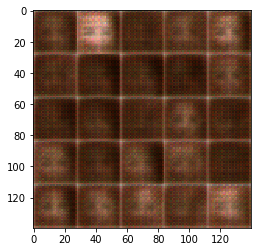

Epoch 1/1 Step 200... Discriminator Loss: 1.5786... Generator Loss: 0.3689


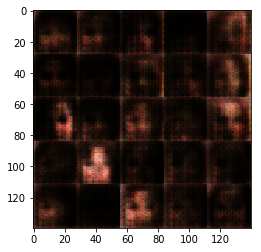

Epoch 1/1 Step 300... Discriminator Loss: 1.7796... Generator Loss: 0.6632


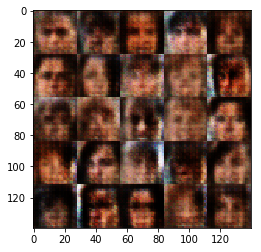

Epoch 1/1 Step 400... Discriminator Loss: 1.5439... Generator Loss: 0.7398


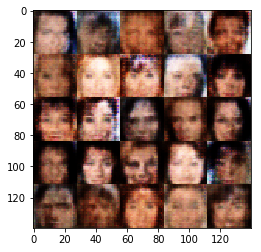

Epoch 1/1 Step 500... Discriminator Loss: 1.3749... Generator Loss: 0.6686


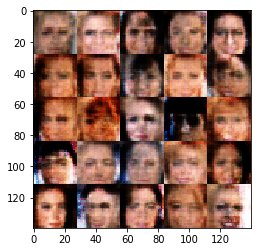

Epoch 1/1 Step 600... Discriminator Loss: 1.8651... Generator Loss: 0.8986


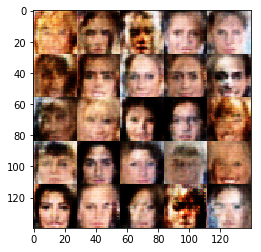

Epoch 1/1 Step 700... Discriminator Loss: 1.7047... Generator Loss: 0.7208


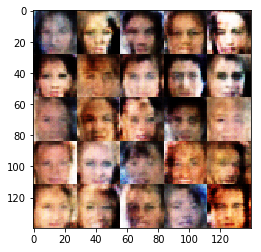

Epoch 1/1 Step 800... Discriminator Loss: 1.4858... Generator Loss: 0.4440


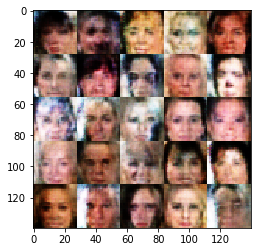

Epoch 1/1 Step 900... Discriminator Loss: 1.3211... Generator Loss: 0.6966


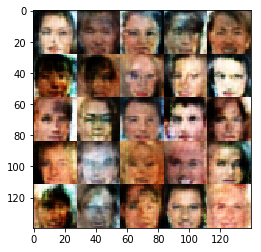

Epoch 1/1 Step 1000... Discriminator Loss: 1.3800... Generator Loss: 0.5915


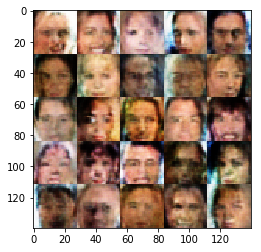

Epoch 1/1 Step 1100... Discriminator Loss: 1.2914... Generator Loss: 0.7061


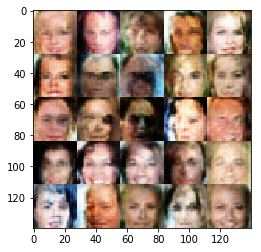

Epoch 1/1 Step 1200... Discriminator Loss: 1.7059... Generator Loss: 0.3310


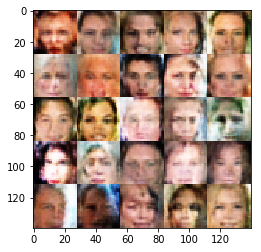

Epoch 1/1 Step 1300... Discriminator Loss: 1.4135... Generator Loss: 0.4731


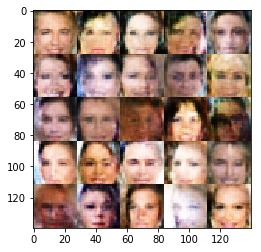

Epoch 1/1 Step 1400... Discriminator Loss: 1.5923... Generator Loss: 0.3551


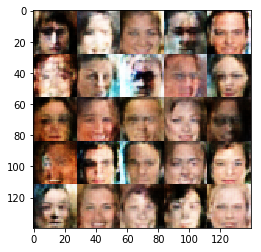

Epoch 1/1 Step 1500... Discriminator Loss: 1.4575... Generator Loss: 0.5592


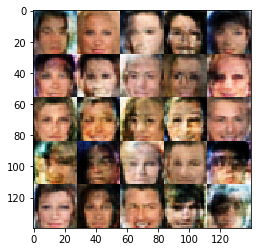

Epoch 1/1 Step 1600... Discriminator Loss: 1.7059... Generator Loss: 0.3186


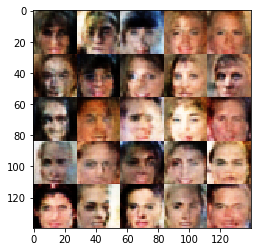

Epoch 1/1 Step 1700... Discriminator Loss: 1.4600... Generator Loss: 0.8652


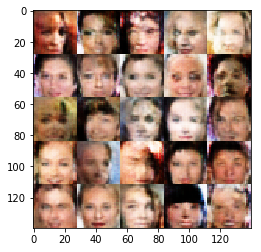

Epoch 1/1 Step 1800... Discriminator Loss: 1.6638... Generator Loss: 0.3315


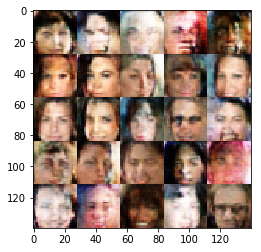

Epoch 1/1 Step 1900... Discriminator Loss: 1.4266... Generator Loss: 0.8357


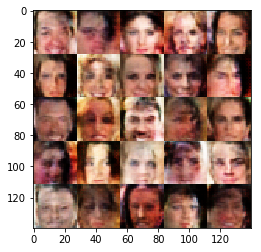

Epoch 1/1 Step 2000... Discriminator Loss: 1.7020... Generator Loss: 0.8693


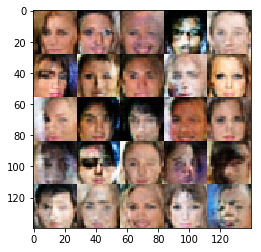

Epoch 1/1 Step 2100... Discriminator Loss: 1.3913... Generator Loss: 0.5103


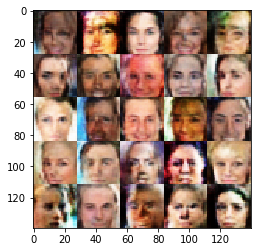

Epoch 1/1 Step 2200... Discriminator Loss: 1.7037... Generator Loss: 0.3115


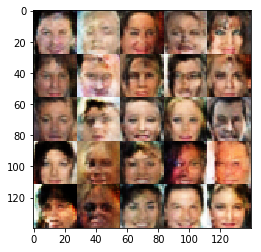

Epoch 1/1 Step 2300... Discriminator Loss: 1.4971... Generator Loss: 0.4074


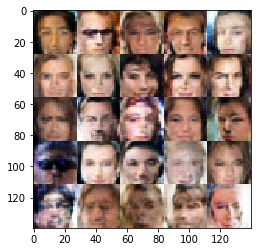

Epoch 1/1 Step 2400... Discriminator Loss: 1.4149... Generator Loss: 0.5212


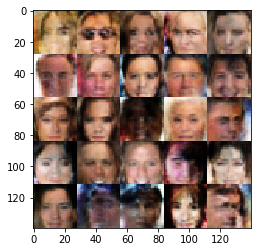

OSError: cannot identify image file './data/img_align_celeba/013102.jpg'

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)